In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [2]:
red = pd.read_csv('data/red_cleaned_final.csv')
red = red.drop(['Unnamed: 0'], axis = 1)

In [ ]:
white = pd.read_csv('data/white_cleaned_final.csv')
white = white.drop(['Unnamed: 0'], axis = 1)

# X - y Split

In [3]:
X_red = red.drop('quality', axis=1)
y_red = red.quality

In [ ]:
X_white = white.drop('quality', axis=1)
y_white = white.quality

# Train - Test Split

In [4]:
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.3, random_state=100)
X_red_train = pd.DataFrame(X_red_train)
y_red_train = pd.DataFrame(y_red_train)
X_red_test = pd.DataFrame(X_red_test)
y_red_test = pd.DataFrame(y_red_test)

In [ ]:
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, y_white, test_size=0.3, random_state=100)
X_white_train = pd.DataFrame(X_white_train)
y_white_train = pd.DataFrame(y_white_train)
X_white_test = pd.DataFrame(X_white_test)
y_white_test = pd.DataFrame(y_white_test)

# Model Red

### Powertransformation X_train and X_test

In [5]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# fit on X_train
ct = ColumnTransformer([("pt", pt, list(X_red_train.columns))], 
                       remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_red_train)

# transform X_train
X_red_train_ct = pd.DataFrame(ct.transform(X_red_train), columns=ct.get_feature_names_out())  

# transform X_test
X_red_test_ct = pd.DataFrame(ct.transform(X_red_test),columns=ct.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing pt, total=   0.0s


### OLS Modelling 

In [6]:
# X_train
X_red_train_const_ct = sm.add_constant(X_red_train_ct.to_numpy()) # adding a constant
model = sm.OLS(y_red_train, X_red_train_const_ct).fit() # fit the model # y_train is not powertransformed
predictions_train = model.predict(X_red_train_const_ct) # predict

# how do you the coef?

# X_test
X_red_test_const_ct = sm.add_constant(X_red_test_ct) # adding a constant on X_test
predictions_test = model.predict(X_red_test_const_ct) # predict


print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     49.69
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.15e-84
Time:                        11:47:43   Log-Likelihood:                -882.11
No. Observations:                 889   AIC:                             1788.
Df Residuals:                     877   BIC:                             1846.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6322      0.022    255.555      0.0

### Predicting

In [9]:
# train
y_red_train_pred = pd.DataFrame(model.predict(X_red_train_const_ct), columns = ['quality'])
y_red_train = y_red_train.reset_index(drop=True)
result_train = pd.concat([y_red_train, y_red_train_pred], axis=1)
result_train

,quality,quality
0,5,5.575673
1,6,6.131333
2,5,5.092918
3,5,5.082457
4,7,5.421231
...,...,...
884,6,5.893911
885,7,5.279963
886,7,5.559989
887,5,5.348997


In [8]:
# test
y_red_pred = pd.DataFrame(model.predict(X_red_test_const_ct), columns = ['quality'] )
y_red_test = y_red_test.reset_index(drop=True)
result_test = pd.concat([y_red_test,y_red_pred], axis=1)
result_test

,quality,quality
0,6,6.032039
1,6,5.820659
2,6,6.376480
3,6,5.835005
4,6,5.611934
...,...,...
376,5,5.433388
377,4,4.842870
378,5,5.683625
379,6,5.324608


## Visualisation

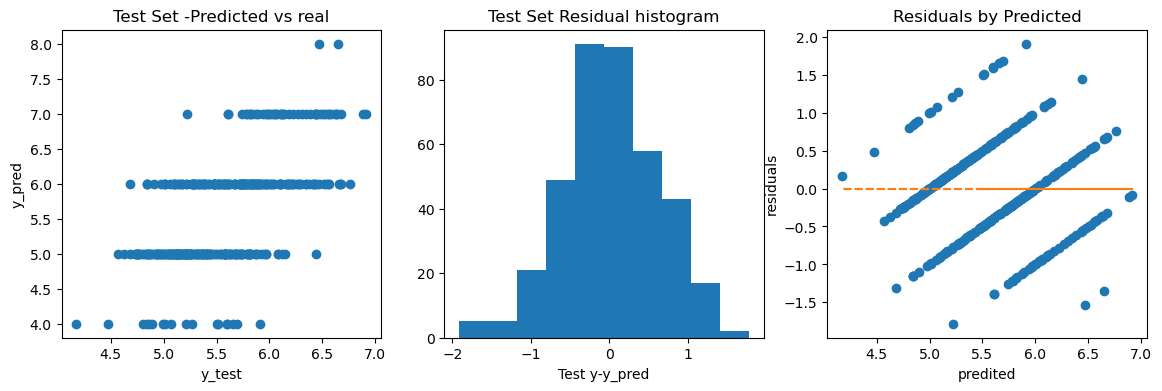

In [10]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_red_pred, y_red_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_red_test - y_red_pred)
            # why here y_test - y_test_pred and below y_test_pred - y_test (as it will always be bigger by nature. ok, got that.)
                    #         
                    # which y_pred is this?
                            # it is about the test y
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")


ax[2].plot(y_red_pred, y_red_pred.to_numpy() - y_red_test.to_numpy(),"o")
                                # here I want to see the negative ones to understand how it goes.
    # y_lr_test_pred, 
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_red_pred,np.zeros(len(y_red_pred)),linestyle='dashed')


In [20]:
features_importances = pd.DataFrame(data={
    'Attribute': X_red_train.columns,
    'Importance': abs(model.coef_.reshape(len(X_red_train.columns),))
})

features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

AttributeError: 'OLSResults' object has no attribute 'coef_'

In [21]:
plt.bar(x=features_importances['Attribute'].iloc[:10], height=features_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation='vertical')
plt.show()

NameError: name 'features_importances' is not defined

### Modelling SciKit Learn

In [18]:
# train model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_red_train_ct, y_red_train)
lr.coef_
lr.intercept_

array([5.63217098])

In [ ]:
# predict
y_red_lr_train_pred =  pd.DataFrame(lr.predict(X_red_train_ct), columns = ['quality'])
y_red_lr_test_pred = pd.DataFrame(lr.predict(X_red_test_ct), columns = ['quality'])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

lr_red_train_mse = mean_squared_error(y_red_train, y_red_lr_train_pred)
lr_red_train_mae = mean_absolute_error(y_red_train, y_red_lr_train_pred)
lr_red_train_r2 = r2_score(y_red_train, y_red_lr_train_pred)
lr_red_train_ar2 = 1 - (1 - lr_red_train_r2) * (len(y_red_train) -1) / (len(y_red_train) - X_red_train.shape[1] - 1)
    # has X_train to be the scaled one?

lr_red_test_mse = mean_squared_error(y_red_test, y_red_lr_test_pred)
lr_red_test_mae = mean_absolute_error(y_red_test, y_red_lr_test_pred)
lr_red_test_r2 = r2_score(y_red_test, y_red_lr_test_pred)
lr_red_test_ar2 = 1 - (1 - lr_red_test_r2) * (len(y_red_test) -1) / (len(y_red_test) - X_red_test.shape[1] - 1)


lr_results = pd.DataFrame(['Linear Regression', lr_red_train_mse, lr_red_test_mse, lr_red_train_mae, lr_red_test_mae, lr_red_train_r2, lr_red_test_r2, lr_red_train_ar2, lr_red_test_ar2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Test MSE', 'Training MAE', 'Test MAE', 'Training R2', 'Test R2', 'Training Ad. R2', 'Test Ad. R2']

lr_results

# Model White

In [ ]:
#X_white_train_pt_f_t = pt.fit_transform(X_white_train)
#X_white_train = pd.DataFrame(X_white_train_pt_f_t)

# y_train

In [ ]:
#y_red_train_pt_f_t = pt.fit_transform(y_red_train)
#y_red_train = pd.DataFrame(y_red_train_pt_f_t)

In [ ]:
#y_white_train_pt_f_t = pt.fit_transform(y_white_train)
#y_white_train = pd.DataFrame(y_white_train_pt_f_t)

## X_test

In [ ]:
#X_red_test_pt_t = pt.transform(X_red_test)
#X_red_test = pd.DataFrame(X_red_test_pt_t)

In [ ]:
#X_white_test_pt_t = pt.transform(X_white_test)
#X_white_test = pd.DataFrame(X_white_test_pt_t)

# y_test

In [ ]:
#y_red_test_pt_t = pt.fit_transform(y_red_test)
#y_red_test = pd.DataFrame(y_red_test_pt_t)

In [ ]:
#y_white_test_pt_t = pt.fit_transform(y_white_test)
#y_white_test = pd.DataFrame(y_white_test_pt_t)

## Rename columns

In [ ]:
def rename_columns(x):
    x.rename(columns={0:'fixed_acidity',1:'volatile_acidity', 2:"citric_acid", 3:'residual_sugar', 4: 'chlorides', 5:"free_sulfur_dioxide", 6:"total_sulfur_dioxide", 7:'density', 8:'ph', 9:'sulphates', 10:'alcohol'}, inplace=True )
    return x

In [ ]:
def rename_columns_y(x):
    x.rename(columns={0:'quality'}, inplace=True )
    return x

In [ ]:
rename_columns(X_red_train)
rename_columns_y(y_red_train)
rename_columns(X_red_test)
rename_columns_y(y_red_test)

In [ ]:
rename_columns(X_white_train)
rename_columns_y(y_white_train)
rename_columns(X_white_test)
rename_columns_y(y_white_test)

# Round

In [ ]:
X_red_train.round(decimals=3)
y_red_train.round(decimals=3)
X_red_test.round(decimals=3)
y_red_test.round(decimals=3)

In [ ]:
X_white_train.round(decimals=3)
y_white_train.round(decimals=3)
X_white_test.round(decimals=3)
y_white_test.round(decimals=3)

# Model

In [ ]:
X_red_train_ct = sm.add_constant(X_red_train.to_numpy()) # adding a constant 
X_red_test_ct = sm.add_constant(X_red_test.to_numpy())

In [ ]:
model_red = sm.OLS(y_red_train, X_red_train_ct).fit()

In [ ]:
pred_red_train = model_red.predict(X_red_train_ct)

In [ ]:
pred_red_test = model_red.predict(X_red_test_ct)

In [ ]:
print_model = model_red.summary()

In [ ]:
print(print_model)

In [ ]:
lr = LinearRegression()
lr.fit(X_red_train, y_red_train)

In [ ]:
lr.coef_

In [ ]:
lr.intercept_